# Product Quantization Experiments

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
from search_approaches import PQ, IVF, ExactSearch
from utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display, Code
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATASET = "siftsmall" # "sift"
DIR = "siftsmall" # "sift"

In [3]:
search_data, queries, tr_data, gt = load_sift(name=DATASET, dir=DIR)
sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))

print("Search vectors shape: ", search_data.shape)
print(f"Base vectors range: [{search_data.min()}, {search_data.max()}]")
print("Query vectors shape: ", queries.shape)
print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", queries.shape)
print("Query example:\n", queries[0])

Search vectors shape:  (10000, 128)
Base vectors range: [0.0, 180.0]
Query vectors shape:  (100, 128)
Ground truth shape:  (100, 100)
Learn vectors shape:  (100, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


In [ ]:
# NOTE: No vectors in search_data are equal to any vector in tr_data
# for i in range(search_data.shape[0]):
#     for j in range(tr_data.shape[0]):
#         if np.array_equal(search_data[i], tr_data[j]):
#             print(f"Row {i} in search_data is equal to row {j} in tr_data")
#             break

# matches = np.where((search_data[:, None] == tr_data).all(axis=2))

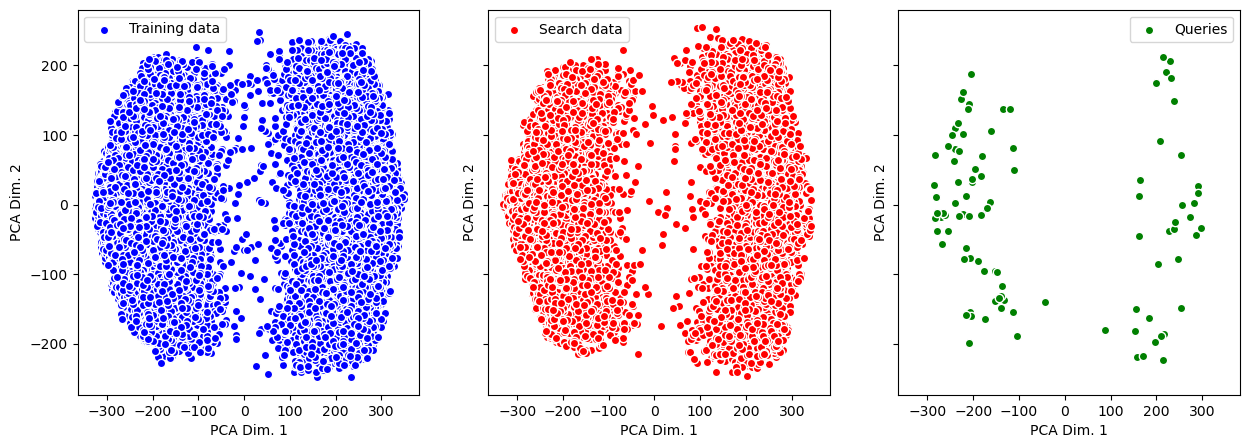

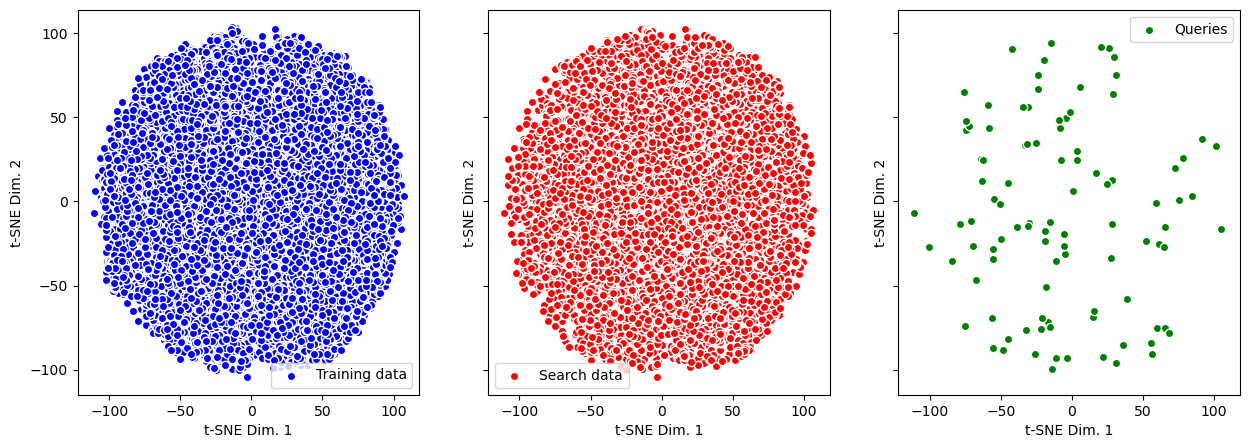

In [78]:
data = np.concatenate([tr_data, search_data, queries], axis=0)

pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data)
tr_data_pca = data_pca[:len(tr_data)]
search_data_pca = data_pca[len(tr_data):len(tr_data) + len(search_data)]
queries_pca = data_pca[len(tr_data) + len(search_data):]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axs[0].scatter(x=tr_data_pca[:, 0], y=tr_data_pca[:, 1], color='blue', label='Training data', edgecolors='white')
axs[1].scatter(x=search_data_pca[:, 0], y=search_data_pca[:, 1], color='red', label='Search data', edgecolors='white')
axs[2].scatter(x=queries_pca[:, 0], y=queries_pca[:, 1], color='green', label='Queries', edgecolors='white')

for i in range(3):
    axs[i].set_xlabel('PCA Dim. 1')
    axs[i].set_ylabel('PCA Dim. 2')
    axs[i].legend()

plt.title("Data Visualization with PCA")
plt.show()

tsne = TSNE(n_components=2, perplexity=5, random_state=RANDOM_SEED)
data_tsne = tsne.fit_transform(data)
tr_data_tsne = data_tsne[:len(tr_data)]
search_data_tsne = data_tsne[len(tr_data):len(tr_data) + len(search_data)]
queries_tsne = data_tsne[len(tr_data) + len(search_data):]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axs[0].scatter(x=tr_data_tsne[:, 0], y=tr_data_tsne[:, 1], color='blue', label='Training data', edgecolors='white')
axs[1].scatter(x=search_data_tsne[:, 0], y=search_data_tsne[:, 1], color='red', label='Search data', edgecolors='white')
axs[2].scatter(x=queries_tsne[:, 0], y=queries_tsne[:, 1], color='green', label='Queries', edgecolors='white')

for i in range(3):
    axs[i].set_xlabel('t-SNE Dim. 1')
    axs[i].set_ylabel('t-SNE Dim. 2')
    axs[i].legend()

plt.title("Data Visualization with t-SNE")
plt.show()

In [ ]:
plt.figure(figsize=(25, 5))
plt.boxplot(tr_data);
plt.title("Training data")
plt.xticks([])
plt.xlabel("Features")
plt.figure(figsize=(25, 5))
plt.boxplot(search_data);
plt.title("Search data")
plt.xticks([])
plt.xlabel("Features")
plt.figure(figsize=(25, 5))
plt.boxplot(queries);
plt.title("Queries")
plt.xticks([])
plt.xlabel("Features");

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


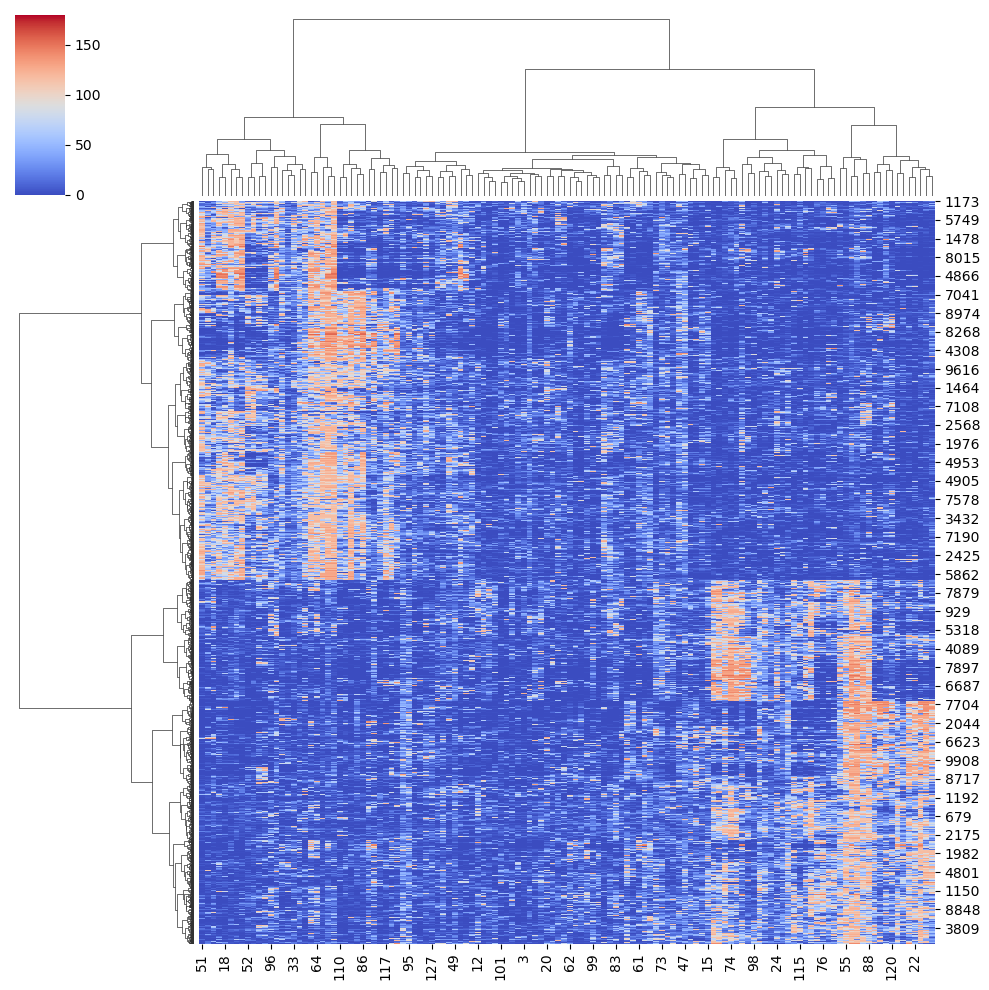

In [4]:
if DATASET == "siftsmall":
    sns.clustermap(search_data, metric='euclidean', cmap='coolwarm', method='ward', figsize=(10, 10))
    plt.show()

In [ ]:
# display PQ implementation
file_path = 'search_approaches.py'
with open(file_path, 'r') as file:
    lines = file.readlines()
selected_lines = ''.join(lines[5:151])
display(Code(data=selected_lines, language='python'))

class PQ:
    def __init__(self, M: int = 8, K: int = 256, kmeans_iter: int = 300,
                 kmeans_minit:str = "k-means++", seed:int = None):
        """
        Product Quantization (PQ) implementation.

        Attributes:
            M (int): Number of subspaces.
            K (int): Number of clusters per subspace.
            kmeans_iter (int): Maximum number of iterations for KMeans.
            kmeans_minit (str): Method for KMeans initialization.
            seed (int): Random seed.
            code_inttype (numpy.dtype): Integer type for storing codes.
            codebook (numpy.ndarray): Cluster centroids for each subspace.
            Ds (int): Dimension of each subspace.
            D (int): Original feature dimension.
            pqcode (numpy.ndarray): Quantized representation of the data.
            avg_dist (numpy.ndarray): Average distortion for each cluster in each subspace.
        """

        self.M = M
        self.K = K
        self.kmeans_iter = kmeans_iter
        self.kmeans_minit = kmeans_minit
        self.seed = seed

        K_bits = np.log2(self.K-1)
        if K_bits <= 8:
            self.code_inttype = np.uint8
        elif K_bits <= 16:
            self.code_inttype = np.uint16
        elif K_bits <= 32:
            self.code_inttype = np.uint32
        else:
            self.code_inttype = np.uint64

        self.codebook = None
        self.Ds = None
        self.pqcode = None
        self.avg_dist = None
        self.inertia = None

    def train(self, data: np.ndarray, add:bool = True,
              compute_distortions:bool = False, verbose:bool = False) -> None:
        """ Train the quantizer on the given data."""
        
        self.D = data.shape[1]
        assert self.D % self.M == 0, "Feature dimension must be divisible by the number of subspaces (M)."
        self.Ds = int(self.D / self.M)
        self.codebook = np.empty((self.M, self.K, self.Ds), np.float32)
        self.inertia = np.empty((self.M))
        self.pqcode = None # if train is called twice, previous codes are discarded
        self.avg_dist = None
        
        if add:
            self.pqcode = np.empty((data.shape[0], self.M), self.code_inttype)
            if compute_distortions:
                self.avg_dist = np.zeros((self.M, self.K), np.float32)

        for m in range(self.M):
            data_sub = data[:, m*self.Ds : (m+1)*self.Ds]
            km = KMeans(n_clusters=self.K, init=self.kmeans_minit, n_init=1,
                random_state=self.seed, max_iter=self.kmeans_iter).fit(data_sub)
            self.inertia[m] = km.inertia_
            if verbose:
                print(f"KMeans on subspace {m+1} converged in {km.n_iter_} iterations with an inertia of {km.inertia_}.")
            
            self.codebook[m] = km.cluster_centers_
            if add:
                self.pqcode[:, m], _ = vq(data_sub, self.codebook[m])
                if compute_distortions:
                    for k in range(self.K):
                        dist = cdist(data_sub[self.pqcode[:, m] == k], [self.codebook[m][k]], 'sqeuclidean')
                        self.avg_dist[m, k] = np.mean(dist)

    # NOTE: una sola volta
    def add(self, data: np.ndarray, compute_distortions:bool = False) -> None:
        """ Add data to the quantizer."""

        assert self.codebook is not None, "The quantizer must be trained before adding data."
        assert data.shape[1] == self.D, "Data dimensions must match trained data dimensions."

        pqcode = self.compress(data)
        self.pqcode = pqcode # if self.pqcode is None else np.vstack((self.pqcode, pqcode))

        if compute_distortions: # recomputed if we train on subspace and add other data
            self.avg_dist = np.zeros((self.M, self.K), np.float32)
            for m in range(self.M):
                data_sub = data[:, m*self.Ds : (m+1)*self.Ds]
                for k in range(self.K):
                    dist = cdist(data_sub[self.pqcode[:, m] == k], [self.code

In [5]:
M = 8
K = 256
pq = PQ(M=M, K=K, seed=RANDOM_SEED)

print("Training the PQ quantizer...")
start_training = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time = time.time() - start_training
start_adding = time.time()
pq.add(search_data)
adding_time = time.time() - start_adding

print("--------------------")
print(f"Training time: {training_time:.2f} s")
print(f"Adding time: {adding_time:.2f} s")
print(f"Compressed data shape: {pq.pqcode.shape}")
print(f"Compressed data size: {pq.pqcode.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor: {tr_data.nbytes / pq.pqcode.nbytes:.2f}")

compressed_tr = pq.compress(tr_data)
decompressed_tr = pq.decompress(compressed_tr) 
error_tr = NMSE(tr_data, decompressed_tr)
print(f"Reconstruction error (NMSE) on training data: {error_tr:.3f}")

decompressed_search = pq.decompress(pq.pqcode)
error_search = NMSE(search_data, decompressed_search)
print(f"Reconstruction error (NMSE) on search data: {error_search:.3f}")

start_training_d = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time_d = time.time() - start_training_d
start_adding_d = time.time()
pq.add(search_data, compute_distortions=True)
adding_time_d = time.time() - start_adding_d

print("--------------------")
print(f"Training time with average distortion computation: {training_time_d:.2f} s")
print(f"Adding time with average distortion computation: {adding_time_d:.2f} s")
print(f"Compressed data shape with average distortion: {pq.pqcode.shape} + {pq.avg_dist.shape}")
print(f"Compressed data with average distortion size: {pq.pqcode.nbytes + pq.avg_dist.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor with average distortion: {tr_data.nbytes / (pq.pqcode.nbytes + pq.avg_dist.nbytes):.2f}")

Training the PQ quantizer...
KMeans on subspace 1 converged in 77 iterations with an inertia of 61875932.0.
KMeans on subspace 2 converged in 79 iterations with an inertia of 64370024.0.
KMeans on subspace 3 converged in 60 iterations with an inertia of 78925296.0.
KMeans on subspace 4 converged in 60 iterations with an inertia of 84752568.0.
KMeans on subspace 5 converged in 55 iterations with an inertia of 78304800.0.
KMeans on subspace 6 converged in 76 iterations with an inertia of 84520048.0.
KMeans on subspace 7 converged in 50 iterations with an inertia of 61301252.0.
KMeans on subspace 8 converged in 68 iterations with an inertia of 63288616.0.
--------------------
Training time: 4.20 s
Adding time: 0.11 s
Compressed data shape: (10000, 8)
Compressed data size: 80000 bytes
Original data size: 12800000 bytes
Compression factor: 160.00
Reconstruction error (NMSE) on training data: 0.089
Reconstruction error (NMSE) on search data: 0.095
KMeans on subspace 1 converged in 77 iterati

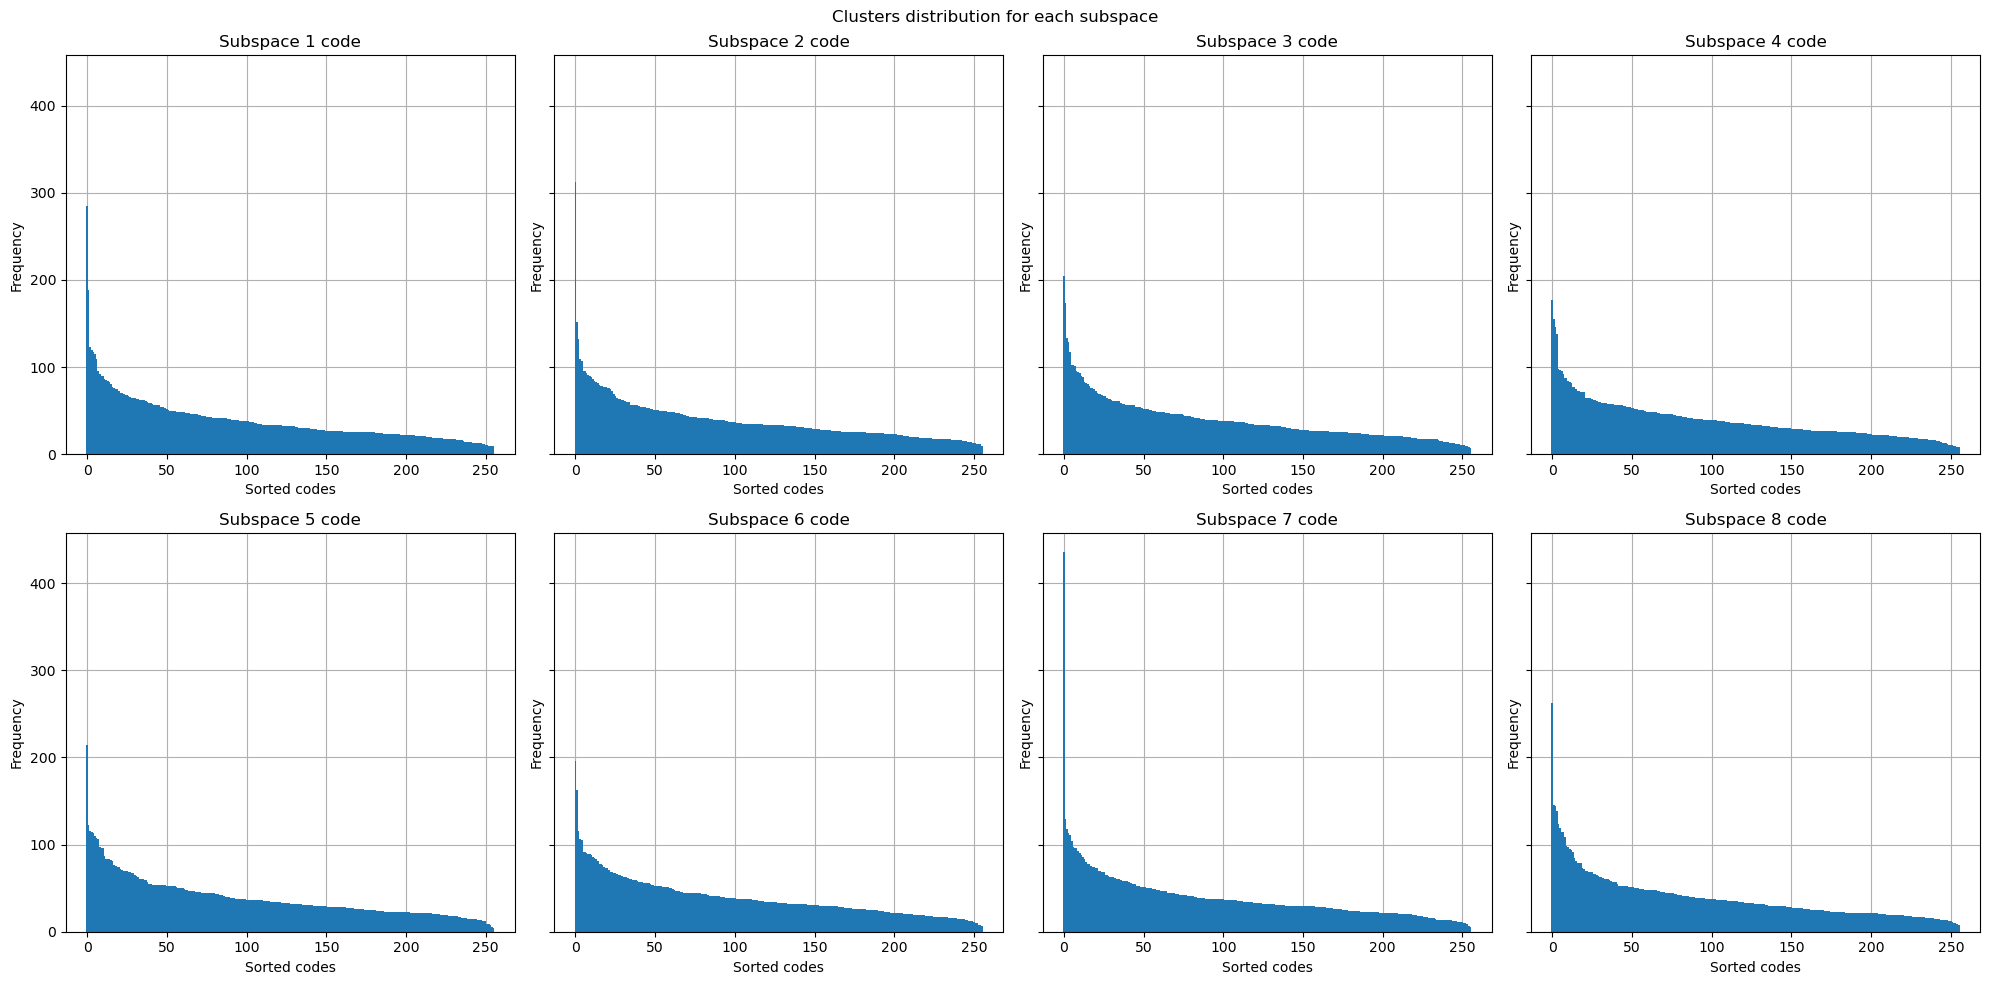

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
id = 0
for m in range(pq.M):
    hist, bins = np.histogram(pq.pqcode[:, m], bins=range(pq.K+1))
    hist = sorted(hist, reverse=True)
    axs[int(id/4)][id%4].bar(bins[:-1], hist, width=1)
    axs[int(id/4)][id%4].set_title(f"Subspace {m+1} code")
    axs[int(id/4)][id%4].set_xlabel("Sorted codes")
    axs[int(id/4)][id%4].set_ylabel("Frequency")
    axs[int(id/4)][id%4].grid()
    axs[int(id/4)][id%4].set_axisbelow(True)
    id += 1

plt.suptitle("Clusters distribution for each subspace")
plt.tight_layout()
plt.show()

In [7]:
asym_pq_dists, asym_ranking = pq.search(sample_query, subset=None, asym=True, correct=False)
asym_pq_corr_dists, asym_corr_ranking = pq.search(sample_query, subset=None, asym=True, correct=True)
sym_pq_dists, sym_ranking = pq.search(sample_query, subset=None, asym=False, correct=False)
sym_pq_corr_dists, sym_corr_ranking = pq.search(sample_query, subset=None, asym=False, correct=True)
es = ExactSearch(search_data)
exact_dists, exact_ranking = es.search(sample_query)

In [8]:
# check if computed exact ranking is equal to ground truth
np.all(gt[0][:100]==exact_ranking[:100])

True

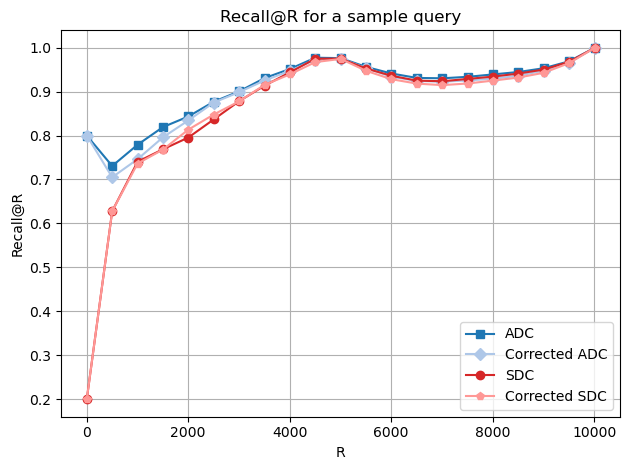

In [9]:
recalls = {"ADC": [], "Corrected ADC": [], "SDC": [], "Corrected SDC": []}
step = 500 if DATASET == "siftsmall" else 100000
rs = range(5, search_data.shape[0] + step, step)
for r in rs:
    recalls["ADC"].append(recall_at_r(asym_ranking, exact_ranking, r))
    recalls["Corrected ADC"].append(recall_at_r(asym_corr_ranking, exact_ranking, r))
    recalls["SDC"].append(recall_at_r(sym_ranking, exact_ranking, r))
    recalls["Corrected SDC"].append(recall_at_r(sym_corr_ranking, exact_ranking, r))

plt.plot(rs, recalls["ADC"], '-s', label="ADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(rs, recalls["Corrected ADC"], '-D', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(rs, recalls["SDC"], '-o', label="SDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(rs, recalls["Corrected SDC"], '-p', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7))
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.title('Recall@R for a sample query')
plt.grid(zorder=0)
plt.tight_layout()
plt.legend();

In [10]:
APs = {}
APs["ADC"] = AP(asym_ranking[:50], exact_ranking[:50])
APs["SDC"] = AP(sym_ranking[:50], exact_ranking[:50])
pd.DataFrame(APs, index=["AP"])

,ADC,SDC
AP,0.746467,0.570353


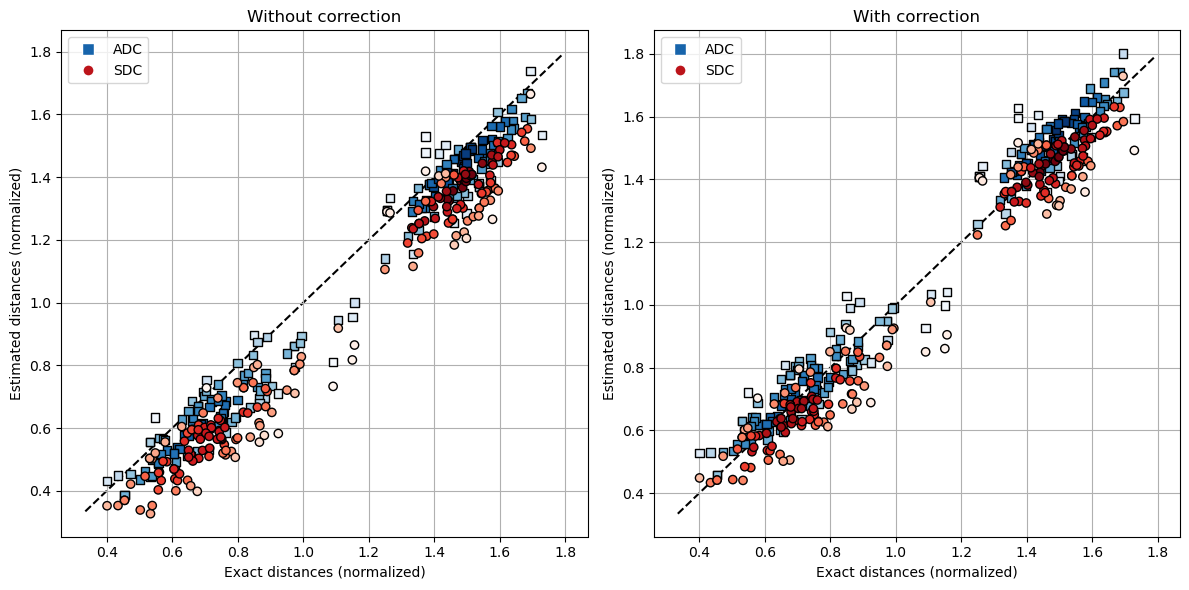

In [11]:
def plot_exact_vs_estimated(axs, exact_dists, asym_pq_dists, sym_pq_dists, query):
    query_snorm = np.sum(np.square(query))
    exact_dists = exact_dists / query_snorm
    asym_pq_dists = asym_pq_dists / query_snorm
    sym_pq_dists = sym_pq_dists / query_snorm
    
    xy_asym = np.vstack([exact_dists, asym_pq_dists])
    kernel_asym = gaussian_kde(xy_asym)(xy_asym)
    axs.scatter(
        exact_dists,
        asym_pq_dists,
        c=kernel_asym,
        cmap="Blues", edgecolor='black', label="ADC",
        zorder=2, marker='s')

    xy_sym = np.vstack([exact_dists, sym_pq_dists])
    kernel_sym = gaussian_kde(xy_sym)(xy_sym)
    axs.scatter(
        exact_dists,
        sym_pq_dists,
        c=kernel_sym,
        cmap="Reds", edgecolor='black', label="SDC",
        zorder=2, marker='o')

    axs.set_xlabel("Exact distances (normalized)")
    axs.set_ylabel("Estimated distances (normalized)")
    xpoints = axs.get_xlim()
    axs.plot(xpoints, xpoints, linestyle='--', color='black', zorder=1)
    axs.grid(zorder=0)
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='ADC', markersize=8,
            markerfacecolor=matplotlib.colormaps['Blues'](0.8)),
        Line2D([0], [0], marker='o', color='w', label='SDC', markersize=8,
            markerfacecolor=matplotlib.colormaps['Reds'](0.8))
    ] # TODO: white border is missing
    axs.legend(handles=legend_elements);

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
SAMPLE_SIZE = 200
sample = np.random.randint(0, 1000, SAMPLE_SIZE)
plot_exact_vs_estimated(axs[0], exact_dists[sample], asym_pq_dists[sample], sym_pq_dists[sample], sample_query)
axs[0].set_title("Without correction")
plot_exact_vs_estimated(axs[1], exact_dists[sample], asym_pq_corr_dists[sample], sym_pq_corr_dists[sample], sample_query)
axs[1].set_title("With correction");
plt.tight_layout()

In [12]:
asym_diffs = np.zeros((search_data.shape[0]*queries.shape[0]))
asym_diffs_corr = np.zeros((search_data.shape[0]*queries.shape[0]))
sym_diffs = np.zeros((search_data.shape[0]*queries.shape[0]))
sym_diffs_corr = np.zeros((search_data.shape[0]*queries.shape[0]))

exact_nearest = np.empty(len(queries))
mean_es_time = 0

for i, query in enumerate(queries):
    asym_d_est, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    asym_d_est_corr, asym_corr_rank = pq.search(query, subset=None, asym=True, correct=True)
    sym_d_est, sym_rank = pq.search(query, subset=None, asym=False, correct=False)
    sym_d_est_corr, sym_corr_rank = pq.search(query, subset=None, asym=False, correct=True)
    query_norm = np.sum(np.square(query))

    start_search_time = time.time()
    d, rank = es.search(query)
    mean_es_time += time.time() - start_search_time
    exact_nearest[i] = rank[0]

    asym_diffs[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (asym_d_est-d) / query_norm
    asym_diffs_corr[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (asym_d_est_corr-d) / query_norm
    sym_diffs[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (sym_d_est-d) / query_norm
    sym_diffs_corr[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (sym_d_est_corr-d) / query_norm

mean_es_time /= len(queries)

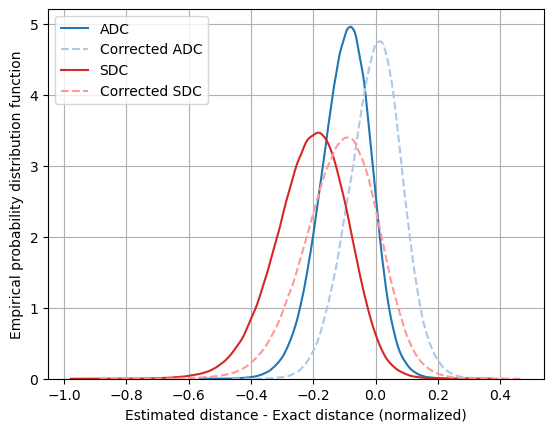

In [13]:
sns.kdeplot(asym_diffs, label="ADC", color=matplotlib.colormaps["tab20"](0))
sns.kdeplot(asym_diffs_corr, label="Corrected ADC", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')
sns.kdeplot(sym_diffs, label="SDC", color=matplotlib.colormaps["tab20"](6))
sns.kdeplot(sym_diffs_corr, label="Corrected SDC", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')
plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend();
plt.grid()

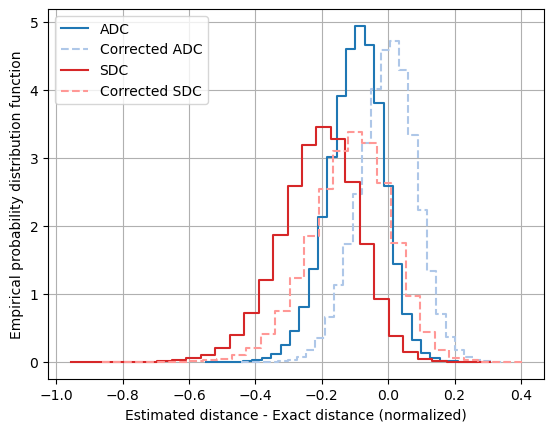

In [14]:
bins = 30

hist_asym, bin_edges_asym = np.histogram(asym_diffs, bins=bins, density=True)
plt.step(bin_edges_asym[:-1], hist_asym, where='post', label="ADC", color=matplotlib.colormaps["tab20"](0))

hist_asym_corr, bin_edges_asym_corr = np.histogram(asym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_asym_corr[:-1], hist_asym_corr, where='post', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')

hist_sym, bin_edges_sym = np.histogram(sym_diffs, bins=bins, density=True)
plt.step(bin_edges_sym[:-1], hist_sym, where='post', label="SDC", color=matplotlib.colormaps["tab20"](6))

hist_sym_corr, bin_edges_sym_corr = np.histogram(sym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_sym_corr[:-1], hist_sym_corr, where='post', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')

plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend()
plt.grid()

In [15]:
asym_diff_var = np.var(asym_diffs)
asym_corr_diff_var = np.var(asym_diffs_corr)
sym_diff_var = np.var(sym_diffs)
sym_corr_diff_var = np.var(sym_diffs_corr)
pd.DataFrame({
    "ADC": [asym_diff_var],
    "Corrected ADC": [asym_corr_diff_var],
    "SDC": [sym_diff_var],
    "Corrected SDC": [sym_corr_diff_var],
    }, index=["Variance of error"])

,ADC,Corrected ADC,SDC,Corrected SDC
Variance of error,0.006804,0.007472,0.01367,0.014333


In [16]:
def compute_recall(index, R, queries, exact_nearest, w=4):
    asym_recall = np.full((len(queries), len(R)), np.nan)
    asym_corr_recall = np.full((len(queries), len(R)), np.nan)
    sym_recall = np.full((len(queries), len(R)), np.nan)
    sym_corr_recall = np.full((len(queries), len(R)), np.nan)

    for i, query in enumerate(queries):
        if type(index) == PQ:
            _, asym_rank = index.search(query, subset=None, asym=True, correct=False)
            _, asym_corr_rank = index.search(query, subset=None, asym=True, correct=True)
            _, sym_rank = index.search(query, subset=None, asym=False, correct=False)
            _, sym_corr_rank = index.search(query, subset=None, asym=False, correct=True)
        else:
            _, asym_rank = index.search(query, w=w, asym=True, correct=False)
            _, asym_corr_rank = index.search(query, w=w, asym=True, correct=True)
            _, sym_rank = index.search(query, w=w, asym=False, correct=False)
            _, sym_corr_rank = index.search(query, w=w, asym=False, correct=True)

        for j, r in enumerate(R):
            if r <= len(asym_rank):
                asym_recall[i][j] = exact_nearest[i] in asym_rank[:r]
            if r <= len(asym_corr_rank):
                asym_corr_recall[i][j] = exact_nearest[i] in asym_corr_rank[:r]
            if r <= len(sym_rank):
                sym_recall[i][j] = exact_nearest[i] in sym_rank[:r]
            if r <= len(sym_corr_rank):
                sym_corr_recall[i][j] = exact_nearest[i] in sym_corr_rank[:r]

    asym_recall_mean = np.nanmean(asym_recall, axis=0)
    asym_corr_recall_mean = np.nanmean(asym_corr_recall, axis=0)
    sym_recall_mean = np.nanmean(sym_recall, axis=0)
    sym_corr_recall_mean = np.nanmean(sym_corr_recall, axis=0)

    results = {
        "asym_recall_mean": asym_recall_mean,
        "asym_corr_recall_mean": asym_corr_recall_mean,
        "sym_recall_mean": sym_recall_mean,
        "sym_corr_recall_mean": sym_corr_recall_mean,
        "inertia": index.inertia
    }

    return results

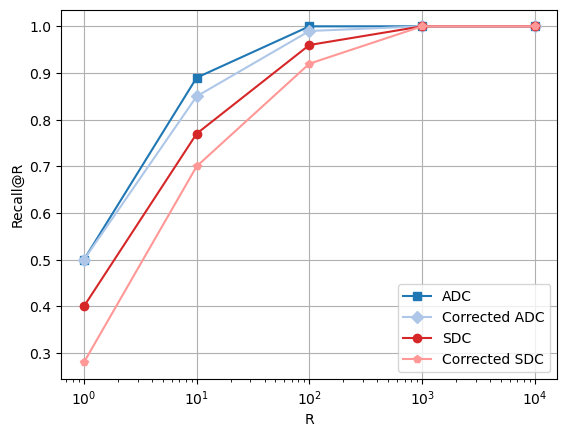

In [17]:
R = [1, 10, 100, 1000, 10000]
if DATASET == "sift":
    R += [100000, 1000000]

results_pq = compute_recall(pq, R, queries, exact_nearest)

plt.plot(R, results_pq ["asym_recall_mean"], '-s', label="ADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_pq ["asym_corr_recall_mean"], '-D', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, results_pq ["sym_recall_mean"], '-o', label="SDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_pq ["sym_corr_recall_mean"], '-p', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

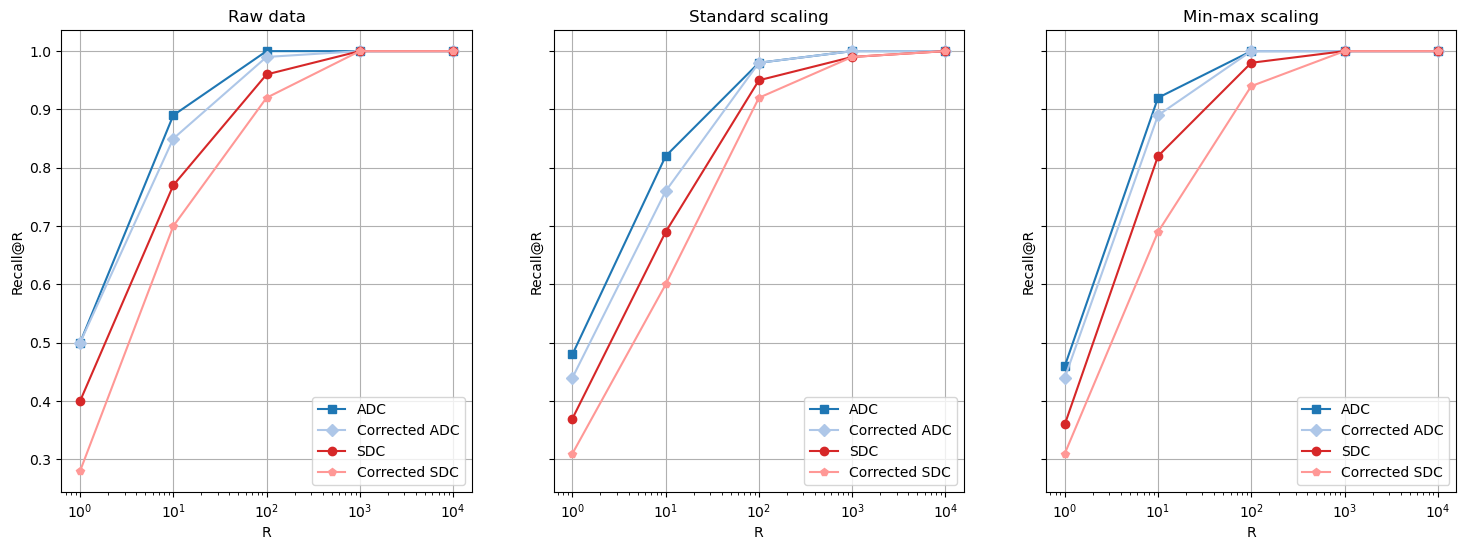

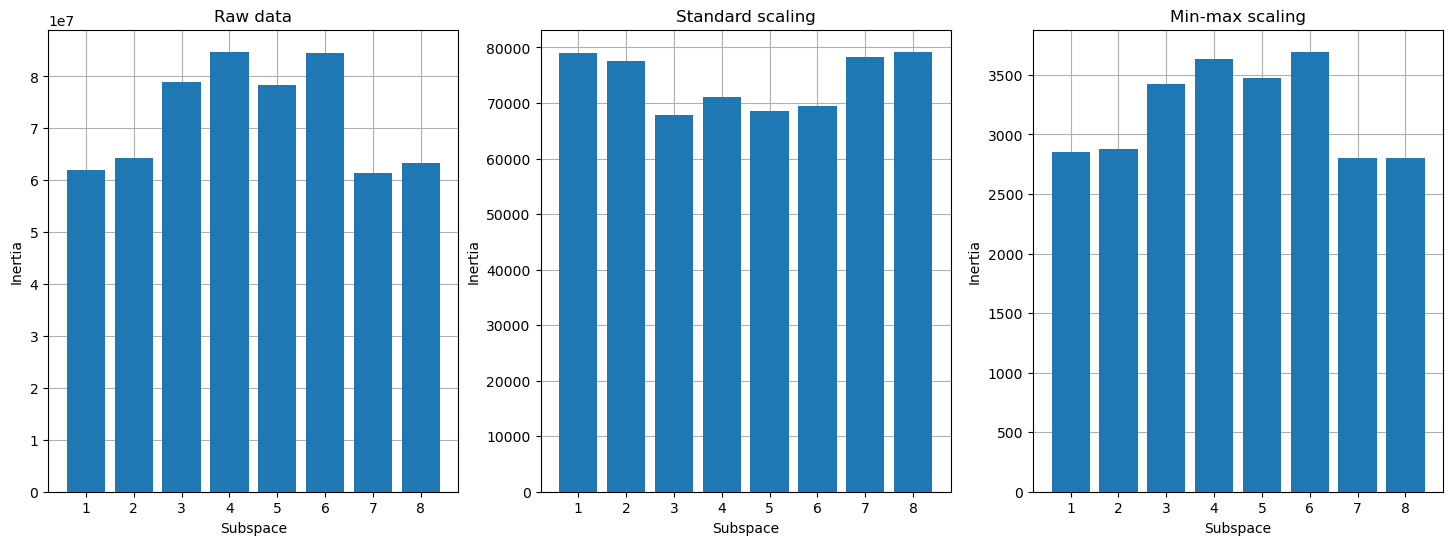

In [18]:
std_scaler = StandardScaler()
# tr_data_std = std_scaler.fit_transform(tr_data)
# search_data_std = std_scaler.transform(search_data)
# queries_std = std_scaler.transform(queries)
search_data_std = std_scaler.fit_transform(search_data)
tr_data_std = std_scaler.transform(tr_data)
queries_std = std_scaler.transform(queries)

minmax_scaler = MinMaxScaler()
# tr_data_minmax = minmax_scaler.fit_transform(tr_data)
# search_data_minmax = minmax_scaler.transform(search_data)
# queries_minmax = minmax_scaler.transform(queries)
search_data_minmax = minmax_scaler.fit_transform(search_data)
tr_data_minmax = minmax_scaler.transform(tr_data)
queries_minmax = minmax_scaler.transform(queries)

pq_std = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_std.train(tr_data_std, add=False)
pq_std.add(search_data_std, compute_distortions=True)
results_pq_std = compute_recall(pq_std, R, queries_std, exact_nearest)

pq_minmax = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_minmax.train(tr_data_minmax, add=False)
pq_minmax.add(search_data_minmax, compute_distortions=True)
results_pq_minmax = compute_recall(pq_minmax, R, queries_minmax, exact_nearest)

scaling_methods = [
    ("Raw data", results_pq),
    ("Standard scaling", results_pq_std),
    ("Min-max scaling", results_pq_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data) in zip(axs, scaling_methods):
    ax.plot(R, data["asym_recall_mean"], '-s', label="ADC", color=matplotlib.colormaps["tab20"](0))
    ax.plot(R, data["asym_corr_recall_mean"], '-D', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1))
    ax.plot(R, data["sym_recall_mean"], '-o', label="SDC", color=matplotlib.colormaps["tab20"](6))
    ax.plot(R, data["sym_corr_recall_mean"], '-p', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Recall@R')
    ax.set_title(title)
    ax.legend()
    ax.grid()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, (title, results) in zip(axs, scaling_methods):
    ax.bar(range(1, results["inertia"].shape[0]+1), results["inertia"], zorder=3)
    ax.set_xlabel('Subspace')
    ax.set_ylabel('Inertia')
    ax.set_title(title)
    ax.grid(zorder=0)
plt.show()

In [19]:
Ms = [1, 2, 4, 8, 16]
Ks = [16, 64, 256, 1024]

training_results = []
search_results = []

for m in Ms:
    for r in Ks:
        print(f"Training PQ with M={m}, K={r}...")
        
        pq = PQ(M=m, K=r, seed=RANDOM_SEED)
        start_training = time.time()
        pq.train(tr_data)
        training_time = time.time() - start_training
        start_adding = time.time()
        pq.add(search_data)
        adding_time = time.time() - start_adding
        
        decompressed_search = pq.decompress(pq.pqcode) 
        search_NMSE = NMSE(search_data, decompressed_search)
        compressed_tr = pq.compress(tr_data)
        decompressed_tr = pq.decompress(compressed_tr)
        tr_NMSE = NMSE(tr_data, decompressed_tr)

        code_length = np.log2(r) * m
        curr_training_res = {"M": m, "K": r, "Code length [bits]": code_length,
                  "Training time [s]": training_time, "Adding time [s]": adding_time,
                  "TR NMSE": tr_NMSE,
                  "SEARCH NMSE": search_NMSE}
        training_results.append(curr_training_res)
        
        for asym in [True, False]:
            mean_search_time = 0
            recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = pq.search(query, subset=None, asym=asym, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_nearest[i] in ranking[:100]:
                    recall_tr += 1
            mean_search_time /= len(queries)
            recall_tr /= len(queries)
            
            curr_search_res = {"M": m, "K": r, "Code length [bits]": code_length,
                          "Asymmetric Distance": asym,
                          "Mean search time [ms]": mean_search_time*1000,
                          "Recall@100": recall_tr}
            search_results.append(curr_search_res)

training_results = pd.DataFrame(training_results)
search_results = pd.DataFrame(search_results)

Training PQ with M=1, K=16...
Training PQ with M=1, K=64...
Training PQ with M=1, K=256...
Training PQ with M=1, K=1024...
Training PQ with M=2, K=16...
Training PQ with M=2, K=64...
Training PQ with M=2, K=256...
Training PQ with M=2, K=1024...
Training PQ with M=4, K=16...
Training PQ with M=4, K=64...
Training PQ with M=4, K=256...
Training PQ with M=4, K=1024...
Training PQ with M=8, K=16...
Training PQ with M=8, K=64...
Training PQ with M=8, K=256...
Training PQ with M=8, K=1024...
Training PQ with M=16, K=16...
Training PQ with M=16, K=64...
Training PQ with M=16, K=256...
Training PQ with M=16, K=1024...


In [20]:
training_results

,M,K,Code length [bits],Training time [s],Adding time [s],TR NMSE,SEARCH NMSE
0,1,16,4.0,0.441555,0.003628,0.295403,0.295698
1,1,64,6.0,1.140679,0.015650,0.254209,0.257719
2,1,256,8.0,2.736609,0.009229,0.220694,0.229798
3,1,1024,10.0,8.126083,0.047837,0.186407,0.211102
4,2,16,8.0,1.020356,0.013980,0.273406,0.276041
5,2,64,12.0,1.546006,0.006675,0.226354,0.229256
6,2,256,16.0,3.241244,0.019184,0.187132,0.195906
7,2,1024,20.0,11.497674,0.052745,0.150360,0.172441
8,4,16,16.0,1.923584,0.009055,0.247365,0.250464
9,4,64,24.0,2.292195,0.019972,0.191399,0.194883


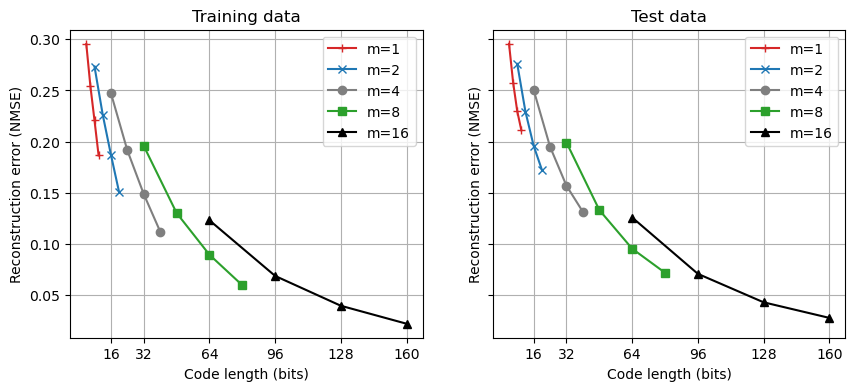

In [21]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
markers = ['+', 'x', 'o', 's', '^']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    res = training_results[training_results["M"]==m]
    axs[0].plot(res["Code length [bits]"], res["TR NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")
    axs[1].plot(res["Code length [bits]"], res["SEARCH NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Reconstruction error (NMSE)")
axs[0].set_title("Training data")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Reconstruction error (NMSE)")
axs[1].set_title("Test data")
axs[1].legend()
axs[1].grid()

In [22]:
print(f"Mean Exact Search time: {mean_es_time*1000} [ms]")
search_results

Mean Exact Search time: 1.381542682647705 [ms]


,M,K,Code length [bits],Asymmetric Distance,Mean search time [ms],Recall@100
0,1,16,4.0,True,0.345330,0.19
1,1,16,4.0,False,0.404687,0.14
2,1,64,6.0,True,0.517282,0.38
3,1,64,6.0,False,0.811939,0.31
4,1,256,8.0,True,0.640235,0.69
5,1,256,8.0,False,0.766301,0.56
6,1,1024,10.0,True,0.752928,0.83
7,1,1024,10.0,False,1.032336,0.65
8,2,16,8.0,True,0.780201,0.42
9,2,16,8.0,False,0.720422,0.39


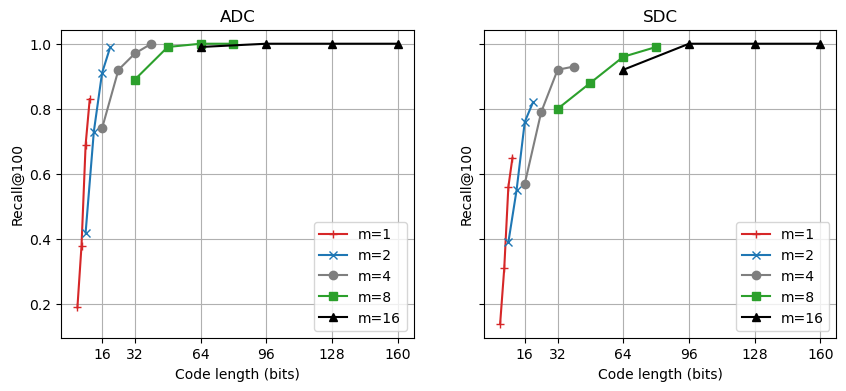

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Recall@100")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Recall@100")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

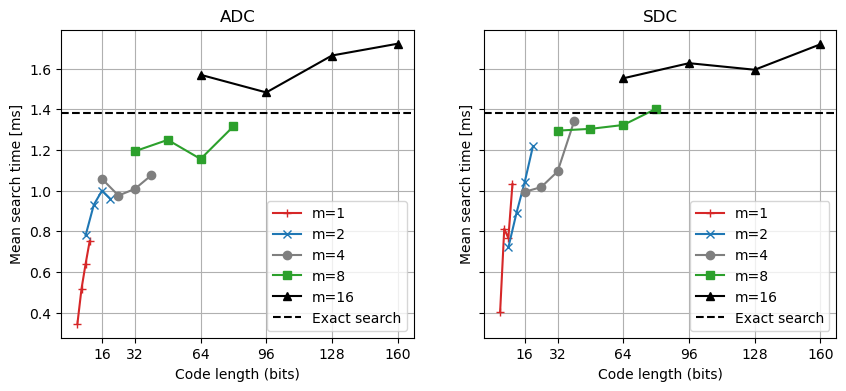

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
axs[1].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Mean search time [ms]")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Mean search time [ms]")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

In [42]:
!cat search_approaches.py

import numpy as np
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

class PQ:
    def __init__(self, M: int = 8, K: int = 256, kmeans_iter: int = 300,
                 kmeans_minit:str = "k-means++", seed:int = None):
        """
        Product Quantization (PQ) implementation.

        Attributes:
            M (int): Number of subspaces.
            K (int): Number of clusters per subspace.
            kmeans_iter (int): Maximum number of iterations for KMeans.
            kmeans_minit (str): Method for KMeans initialization.
            seed (int): Random seed.
            code_inttype (numpy.dtype): Integer type for storing codes.
            codebook (numpy.ndarray): Cluster centroids for each subspace.
            Ds (int): Dimension of each subspace.
            D (int): Original feature dimension.
            pqcode (numpy.ndarray): Quantized representation of the data.
            avg_dist (numpy.ndarray): Average di

In [45]:
# display IVF implementation
with open(file_path, 'r') as file:
    lines = file.readlines()
selected_lines = ''.join(lines[152:259])
display(Code(data=selected_lines, language='python'))

class IVF:
    def __init__(self, Kp: int = 1024, M:int = 8, K:int = 256,
                 kmeans_iter:int = 300, kmeans_minit:str = "k-means++",
                 seed:int = None):
        """
        Inverted File (IVF) implementation with Product Quantization (PQ).
    
        Attributes:
            Kp (int): Number of clusters for the coarse quantizer.
            kmeans_iter (int): Maximum number of iterations for KMeans.
            kmeans_minit (str): Method for KMeans initialization.
            seed (int, optional): Random seed.
            ivf (list of np.ndarray): Inverted index storing data indices assigned to each centroid.
            num_els (int): Total number of vectors added to the index.
            centroids (np.ndarray): Coarse quantizer cluster centroids.
            pq (PQ): Product Quantizer instance for quantizing residuals.
        """

        self.Kp = Kp
        self.kmeans_iter = kmeans_iter
        self.kmeans_minit = kmeans_minit
        self.seed = seed
        self.ivf = None
        self.num_els = 0
        self.centroids = None
        self.inertia = None
        self.pq = PQ(M=M, K=K, kmeans_iter=self.kmeans_iter,
                     kmeans_minit=self.kmeans_minit, seed=None)

    def train(self, data: np.ndarray, add:bool = True,
              compute_distortions:bool = False, verbose:bool = False) -> None:
        """Train the IVF on the given data."""
        
        assert data.shape[0] > self.Kp, "Number of vectors must be greater than the number of centroids."
        
        self.num_els = 0
        self.ivf = None

        km = KMeans(n_clusters=self.Kp, init=self.kmeans_minit, n_init=1,
            random_state=self.seed, max_iter=self.kmeans_iter).fit(data)
        self.inertia = km.inertia_
        if verbose:
            print(f"KMeans for IVF converged in {km.n_iter_} iterations.")
        
        self.centroids = km.cluster_centers_
        labels, _ = vq(data, self.centroids)

        if add:
            self.ivf = [np.where(labels == i)[0] for i in range(self.Kp)]
            self.num_els = data.shape[0]
        
        residuals = data - self.centroids[labels]
        self.pq.train(residuals, add=add, compute_distortions=compute_distortions,
                      verbose=verbose)

    # NOTE: una sola volta
    def add(self, data: np.ndarray, compute_distortions:bool = False) -> None:
        """Add data to the IVF structure."""
        
        assert self.centroids is not None, "The index must be created before adding data."
        assert data.shape[1] == self.pq.D, "Data dimensions must match trained data dimensions."

        labels, _ = vq(data, self.centroids)
        self.ivf = [np.where(labels == i)[0] for i in range(self.Kp)]
        self.num_els = data.shape[0]
        
        residuals = data - self.centroids[labels]
        self.pq.add(residuals, compute_distortions=compute_distortions)

        # for i in range(self.Kp):
        #     els_i = np.where(labels == i)[0]
        #     if els_i.shape[0] > 0:
        #         self.ivf[i] = np.hstack((self.ivf[i], els_i))

    def search(self, query: np.ndarray, w:int = 8, asym:bool = True,
               correct:bool = False, sort:bool = True) -> tuple[np.ndarray, np.ndarray]:
        """Search for the closest vectors to the query in the IVF index."""
        
        assert w <= self.Kp, "Number of centroids to visit must be less or equal to the number of centroids."
        assert self.centroids is not None, "The index must be created before searching."
        assert self.ivf is not None, "Vectors must be added before searching."
        assert len(query) == self.pq.D, "Query dimensions must match trained data dimensions."

        dist2centroids = cdist([query], self.centroids, 'sqeuclidean')[0]
        sorted_centroids = np.argsort(dist2centroids)
        els_per_centroid = np.array([len(self.ivf[centroid]) for centroid in sorted_centroids])
        num_els = np.sum(els_per_centroid[:w])
        dists =

In [ ]:
W = 8
if DATASET == "siftsmall":
    KP = 128
else:
    KP = 1024

ivf = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
start_training = time.time()
ivf.train(tr_data, add=False)
end_training = time.time() - start_training

start_adding = time.time()
ivf.add(search_data, compute_distortions=True)
end_adding = time.time() - start_adding

print(f"Training time (with avg dist computation): {end_training:.2f} s")
print(f"Adding time (with avg dist computation): {end_adding:.2f} s")

Training time (with avg dist computation): 5.81 s
Adding time (with avg dist computation): 0.26 s


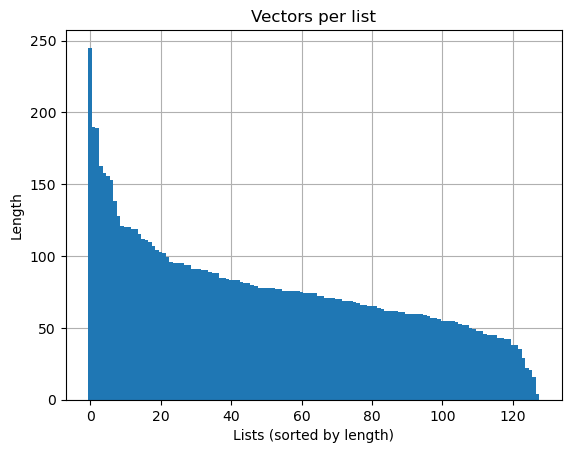

In [26]:
els_per_cluster = []
for i in range(ivf.Kp):
    els_per_cluster.append(len(ivf.ivf[i]))
fig, axs = plt.subplots(1)
axs.bar(range(ivf.Kp), sorted(els_per_cluster, reverse=True), width=1.0)
axs.set_xlabel("Lists (sorted by length)")
axs.set_ylabel("Length")
axs.set_title("Vectors per list")
axs.set_axisbelow(True)
axs.grid()

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:29: RuntimeWarning: Mean of empty slice
  asym_recall_mean = np.nanmean(asym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:30: RuntimeWarning: Mean of empty slice
  asym_corr_recall_mean = np.nanmean(asym_corr_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:31: RuntimeWarning: Mean of empty slice
  sym_recall_mean = np.nanmean(sym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:32: RuntimeWarning: Mean of empty slice
  sym_corr_recall_mean = np.nanmean(sym_corr_recall, axis=0)


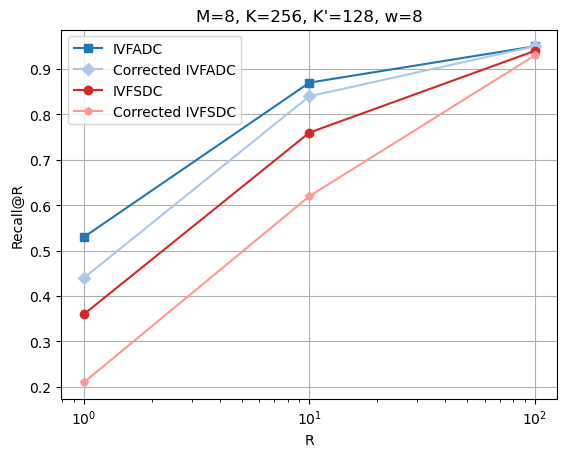

In [27]:
results_ivf = compute_recall(ivf, R, queries, exact_nearest, w=W)

plt.plot(R, results_ivf["asym_recall_mean"], '-s', label="IVFADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_ivf["asym_corr_recall_mean"], '-D', label="Corrected IVFADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, results_ivf["sym_recall_mean"], '-o', label="IVFSDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_ivf["sym_corr_recall_mean"], '-p', label="Corrected IVFSDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.title(f"M={M}, K={K}, K'={KP}, w={W}")
plt.legend()
plt.grid()

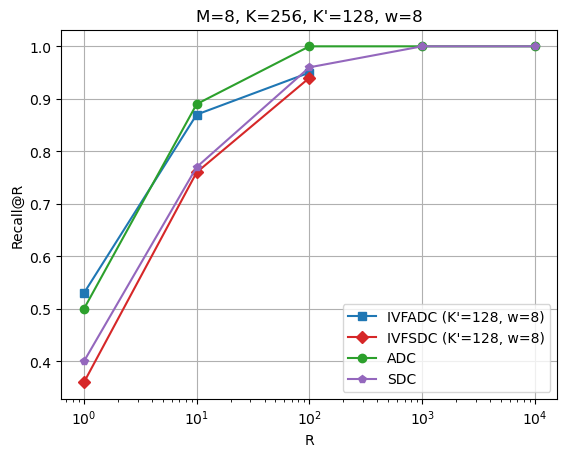

In [ ]:
plt.plot(R, results_ivf["asym_recall_mean"], '-s', label=f"IVFADC (K'={KP}, w={W})", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_ivf["sym_recall_mean"], '-D', label=f"IVFSDC (K'={KP}, w={W})", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_pq["asym_recall_mean"], '-o', label="ADC", color=matplotlib.colormaps["tab20"](4))
plt.plot(R, results_pq["sym_recall_mean"], '-p', label="SDC", color=matplotlib.colormaps["tab20"](8))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.title(f"M={M}, K={K}, K'={KP}, w={W}")
plt.legend()
plt.grid()

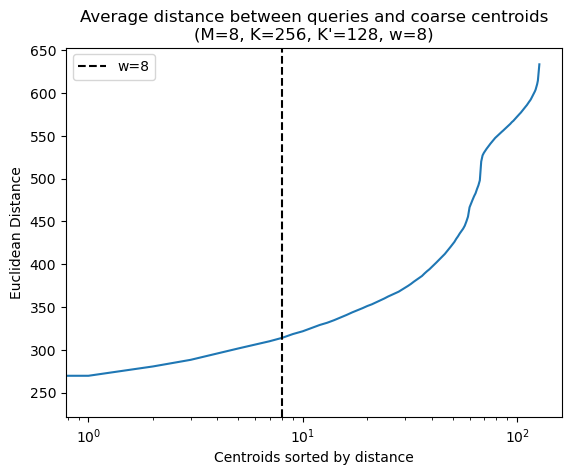

In [29]:
mean_dists2centroids = np.zeros(ivf.Kp)

for i, query in enumerate(queries):
    _, ivf_asym_rank = ivf.search(query, w=W, asym=True, correct=False)
    dist2centroids = cdist([query], ivf.centroids, 'euclidean')[0]
    sorteddist2centroids = np.sort(dist2centroids)
    mean_dists2centroids += sorteddist2centroids

mean_dists2centroids /= len(queries)

plt.plot(mean_dists2centroids)
plt.xlabel("Centroids sorted by distance")
plt.ylabel("Euclidean Distance")
plt.axvline(x=W, color='k', linestyle='--', label=f"w={W}")
plt.xscale('log')
plt.legend()
plt.title(f"Average distance between queries and coarse centroids\n(M={M}, K={K}, K'={KP}, w={W})");

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:29: RuntimeWarning: Mean of empty slice
  asym_recall_mean = np.nanmean(asym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:30: RuntimeWarning: Mean of empty slice
  asym_corr_recall_mean = np.nanmean(asym_corr_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:31: RuntimeWarning: Mean of empty slice
  sym_recall_mean = np.nanmean(sym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_23110/1030522892.py:32: RuntimeWarning: Mean of empty slice
  sym_corr_recall_mean = np.nanmean(sym_corr_recall, axis=0)
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value enco

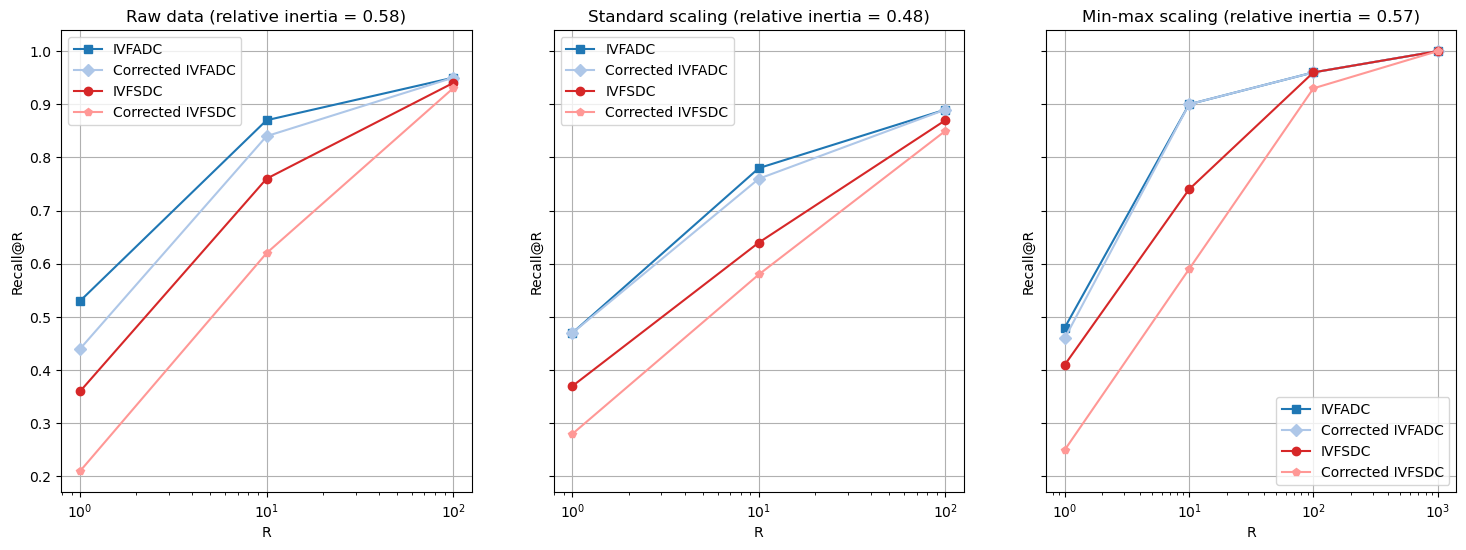

In [30]:
ivf_std = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_std.train(tr_data_std, add=False)
ivf_std.add(search_data_std, compute_distortions=True)
results_ivf_std = compute_recall(ivf_std, R, queries_std, exact_nearest, w=W)

ivf_minmax = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_minmax.train(tr_data_minmax, add=False)
ivf_minmax.add(search_data_minmax, compute_distortions=True)
results_ivf_minmax = compute_recall(ivf_minmax, R, queries_minmax, exact_nearest, w=W)

def compute_overall_inertia(data):
    mean = np.mean(data, axis=0)
    return np.sum(np.square(data - mean))

overall_inertia = compute_overall_inertia(tr_data)
overall_inertia_std = compute_overall_inertia(tr_data_std)
overall_inertia_minmax = compute_overall_inertia(tr_data_minmax)

scaling_methods_ivf = [
    ("Raw data", results_ivf, overall_inertia),
    ("Standard scaling", results_ivf_std, overall_inertia_std),
    ("Min-max scaling", results_ivf_minmax, overall_inertia_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data, overall_inertia) in zip(axs, scaling_methods_ivf):
    ax.plot(R, data["asym_recall_mean"], '-s', label="IVFADC", color=matplotlib.colormaps["tab20"](0))
    ax.plot(R, data["asym_corr_recall_mean"], '-D', label="Corrected IVFADC", color=matplotlib.colormaps["tab20"](1))
    ax.plot(R, data["sym_recall_mean"], '-o', label="IVFSDC", color=matplotlib.colormaps["tab20"](6))
    ax.plot(R, data["sym_corr_recall_mean"], '-p', label="Corrected IVFSDC", color=matplotlib.colormaps["tab20"](7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Recall@R')
    ax.set_title(f"{title} (relative inertia = {1-(data['inertia'] / overall_inertia):.2f})")
    ax.legend()
    ax.grid()
plt.show()

In [ ]:
K = 256
Ms = [1, 2, 4, 8, 16]
if DATASET == "siftsmall":
    Kps = [16, 128]
    ws = [1, 2, 8]
else:
    Kps = [1024, 8192]
    ws = [1, 8, 64]

ivf_training_results = []
ivf_search_results = []

for m in Ms:
    for Kp in Kps:
        print(f"Training PQ with M={m}, K'={Kp}...")
        
        ivf = IVF(Kp=Kp, M=m, K=K, seed=RANDOM_SEED)
        start_training = time.time()
        ivf.train(tr_data, add=False)
        training_time = time.time() - start_training
        start_adding = time.time()
        ivf.add(search_data)
        adding_time = time.time() - start_adding

        code_length = np.log2(K) * m
        curr_training_res = {"M": m, "K": K, "Kp": Kp,
                             "Code length [bits]": code_length,
                             "Training time [s]": training_time,
                             "Adding time [s]": adding_time}
        ivf_training_results.append(curr_training_res)
        
        for w in ws:
            if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
            mean_search_time = 0
            recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = ivf.search(query, w=w, asym=True, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_nearest[i] in ranking[:100]:
                    recall_tr += 1
            mean_search_time /= len(queries)
            recall_tr /= len(queries)
            
            curr_search_res = {"M": m, "K": K, "Kp": Kp, "w":w,
                               "Code length [bits]": code_length,
                               "Mean search time [ms]": mean_search_time*1000,
                               "Recall@100": recall_tr}
            ivf_search_results.append(curr_search_res)

ivf_training_results = pd.DataFrame(ivf_training_results)
ivf_search_results = pd.DataFrame(ivf_search_results)

Training PQ with M=1, K'=16...
Training PQ with M=1, K'=128...
Training PQ with M=2, K'=16...
Training PQ with M=2, K'=128...
Training PQ with M=4, K'=16...
Training PQ with M=4, K'=128...
Training PQ with M=8, K'=16...
Training PQ with M=8, K'=128...
Training PQ with M=16, K'=16...
Training PQ with M=16, K'=128...


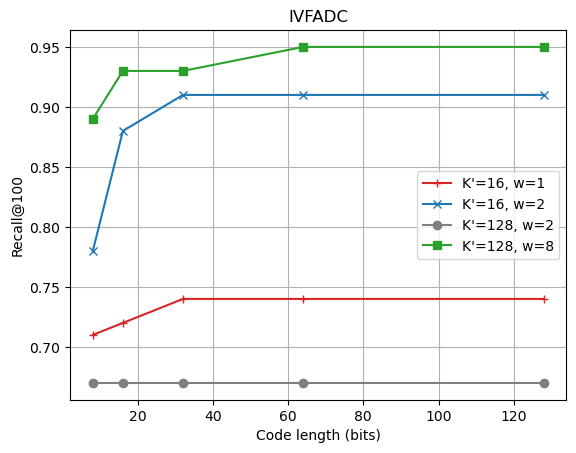

In [32]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Recall@100"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.xlabel("Code length (bits)")
plt.ylabel("Recall@100")
plt.title("IVFADC")
plt.legend()
plt.grid()

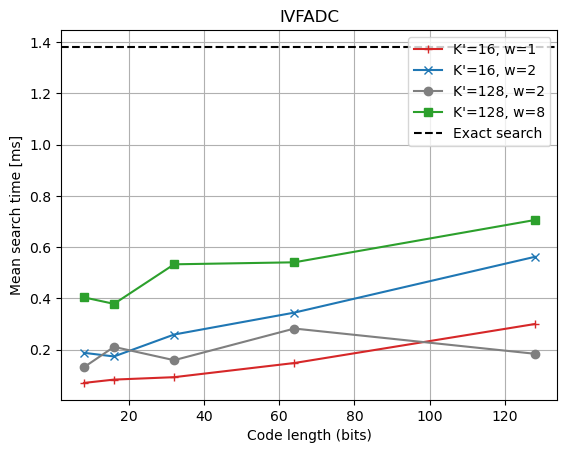

In [33]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
            continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

plt.xlabel("Code length (bits)")
plt.ylabel("Mean search time [ms]")
plt.title("IVFADC")
plt.legend()
plt.grid()

In [34]:
ivf_search_results[(ivf_search_results["M"]==8)]

,M,K,Kp,w,Code length [bits],Mean search time [ms],Recall@100
12,8,256,16,1,64.0,0.147929,0.74
13,8,256,16,2,64.0,0.344629,0.91
14,8,256,128,2,64.0,0.282433,0.67
15,8,256,128,8,64.0,0.540912,0.95


In [35]:
search_results[(search_results["M"]==8) & (search_results["K"]==256)]

,M,K,Code length [bits],Asymmetric Distance,Mean search time [ms],Recall@100
28,8,256,64.0,True,1.155279,1.00
29,8,256,64.0,False,1.322486,0.96


<img src="./img/sift_img.png" alt="My Image" width="500"/>

For the m = 4 SIFT quantizer, this means that the 4×4 patch cells that make up the descriptor are grouped into 4 2 × 2 blocks. For the other two, it groups together dimensions that have have the same index modulo 8.

Training PQ with structured permutation on training data...
Training PQ with natural permutation on training data...
[1/5] Training PQ with random permutation on training data...
[2/5] Training PQ with random permutation on training data...
[3/5] Training PQ with random permutation on training data...
[4/5] Training PQ with random permutation on training data...
[5/5] Training PQ with random permutation on training data...


,natural,structured,random mean,random std
recall@10,0.72,0.73,0.674,0.044542


In [40]:
struct_perm = list(range(0, 16)) + list(range(32, 48)) + \
    list(range(16, 32)) + list(range(48, 64)) + \
    list(range(64, 80)) + list(range(96, 112)) + \
    list(range(80, 96)) + list(range(112, 128))
tr_data_struct_perm = tr_data[:, struct_perm]
queries_struct_perm = queries[:, struct_perm]
search_data_struct_perm = search_data[:, struct_perm]

pq_struct_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with structured permutation on training data...")
pq_struct_perm.train(tr_data_struct_perm, add=False)
pq_struct_perm.add(search_data_struct_perm)

recall_struct_perm_tr = np.zeros(queries_struct_perm.shape[0])
for i, query in enumerate(queries_struct_perm):
    _, asym_struct_perm_rank = pq_struct_perm.search(query, subset=None, asym=True, correct=False)
    recall_struct_perm_tr[i] = exact_nearest[i] in asym_struct_perm_rank[:10]
recall_struct_perm_tr = np.mean(recall_struct_perm_tr)

pq = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with natural permutation on training data...")
pq.train(tr_data, add=False)
pq.add(search_data)

recall_tr = np.zeros(queries.shape[0])
for i, query in enumerate(queries):
    _, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    recall_tr[i] = exact_nearest[i] in asym_rank[:10]
recall_tr = np.mean(recall_tr)

recalls_rand_perm_tr = []
for rep in range(0, 5):
    rand_perm = np.random.permutation(128)
    tr_data_rand_perm = tr_data[:, rand_perm]
    queries_rand_perm = queries[:, rand_perm]
    search_data_rand_perm = search_data[:, rand_perm]

    pq_rand_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
    print(f"[{rep+1}/5] Training PQ with random permutation on training data...")
    pq_rand_perm.train(tr_data_rand_perm, add=False)
    pq_rand_perm.add(search_data_rand_perm)

    recall_rand_perm = np.zeros(queries_rand_perm.shape[0])
    for i, query in enumerate(queries_rand_perm):
        _, asym_rand_perm_rank = pq_rand_perm.search(query, subset=None, asym=True, correct=False)
        recall_rand_perm[i] = exact_nearest[i] in asym_rand_perm_rank[:10]
    recall_rand_perm = np.mean(recall_rand_perm)

    recalls_rand_perm_tr.append(recall_rand_perm)

recall_rand_perm_mean_tr = np.mean(recalls_rand_perm_tr)
recall_rand_perm_std_tr = np.std(recalls_rand_perm_tr)

print("--------")

print("Training PQ with structured permutation on search data...")
pq_struct_perm.train(search_data_struct_perm, add=True)

recall_struct_perm_search = np.zeros(queries_struct_perm.shape[0])
for i, query in enumerate(queries_struct_perm):
    _, asym_struct_perm_rank = pq_struct_perm.search(query, subset=None, asym=True, correct=False)
    recall_struct_perm_search[i] = exact_nearest[i] in asym_struct_perm_rank[:10]
recall_struct_perm_search = np.mean(recall_struct_perm_search)

print("Training PQ with natural permutation on search data...")
pq.train(search_data, add=True)

recall_search = np.zeros(queries.shape[0])
for i, query in enumerate(queries):
    _, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    recall_search[i] = exact_nearest[i] in asym_rank[:10]
recall_search = np.mean(recall_search)

recalls_rand_perm_search = []
for rep in range(0, 5):
    rand_perm = np.random.permutation(128)
    tr_data_rand_perm = tr_data[:, rand_perm]
    queries_rand_perm = queries[:, rand_perm]
    search_data_rand_perm = search_data[:, rand_perm]

    print(f"[{rep+1}/5] Training PQ with random permutation on search data...")
    pq_rand_perm.train(search_data_rand_perm, add=True)

    recall_rand_perm = np.zeros(queries_rand_perm.shape[0])
    for i, query in enumerate(queries_rand_perm):
        _, asym_rand_perm_rank = pq_rand_perm.search(query, subset=None, asym=True, correct=False)
        recall_rand_perm[i] = exact_nearest[i] in asym_rand_perm_rank[:10]
    recall_rand_perm = np.mean(recall_rand_perm)

    recalls_rand_perm_search.append(recall_rand_perm)

recall_rand_perm_mean_search = np.mean(recalls_rand_perm_search)
recall_rand_perm_std_search = np.std(recalls_rand_perm_search)

pd.DataFrame({
    "natural": [recall_tr, recall_search],
    "structured": [recall_struct_perm_tr, recall_struct_perm_search],
    "random mean": [recall_rand_perm_mean_tr, recall_rand_perm_mean_search],
    "random std": [recall_rand_perm_std_tr, recall_rand_perm_std_search]
}, index=["recall@10 (training data)", "recall@10 (search data)"])

Training PQ with structured permutation on training data...
Training PQ with natural permutation on training data...
[1/5] Training PQ with random permutation on training data...
[2/5] Training PQ with random permutation on training data...
[3/5] Training PQ with random permutation on training data...
[4/5] Training PQ with random permutation on training data...
[5/5] Training PQ with random permutation on training data...
--------
Training PQ with structured permutation on search data...
Training PQ with natural permutation on search data...
[1/5] Training PQ with random permutation on search data...
[2/5] Training PQ with random permutation on search data...
[3/5] Training PQ with random permutation on search data...
[4/5] Training PQ with random permutation on search data...
[5/5] Training PQ with random permutation on search data...


,natural,structured,random mean,random std
recall@10 (training data),0.72,0.73,0.690,0.020
recall@10 (search data),0.72,0.83,0.688,0.024


In [38]:
KP*128, 10000/KP
# numero di entries da confrontare per ogni query
# punti per centroide

(16384, 78.125)

In [39]:
# dist_table:
#   1 ... 256
# 1
# 2
# 3
# 4

# pqcode:
#    1     2     3     4
# p1 1-256
# ...
# pn

# dist_table[[1, 2, 3, 4]], pqcode]